In [1]:
# CUDA
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import torch
print("CUDA?", torch.cuda.is_available())
x = torch.rand(10).cuda()

# NOTEBOOK
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
%matplotlib notebook

# IMPORTS
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
from math import floor
import torchvision
import pickle
import time
import cupy as cp

from images import imread, pt2np, imwrite
from ResizeRight.resize_right import resize

from config import default_config as config
from utils import prob_hist, plot_hist, load_pickle, kl_divergence
from main import our_score
from swd import weights_map_to_image
from pyramid import pyramid_shapes_scale_sqrt_2
from degrade import degrade

CUDA? True


## dataset_huge  -->  dataset

In [ ]:
import torchvision
degradations = ["big_blur", "small_blur", "reference", "small_wn", "big_wn"]
for image_name in os.listdir(os.path.join(base_path, "dataset_huge")):
    image_path = os.path.join(base_path, "dataset_huge", image_name)
    original_image = imread(image_path)
    
    image_scales = pyramid_scale_sqrt_2_shapes(original_image, num_scales=9, patch_size=5, dim_max_size=1024)
    # resize to hr
    hr_image = resize(original_image, out_shape=image_scales[0]).clip(0, 1)
    
    for degradation in degradations:
        # degrade hr
        degraded = degrade(reference=hr_image, degradation=degradation).clip(0, 1)
    
        for scale_id, out_shape in enumerate(image_scales):
            curr_im = resize(degraded, out_shape=out_shape).clip(0, 1)
            imwrite(fname=os.path.join(base_path, "dataset_pyramid", f"image_{str(int(image_name[:-4]))}_degradation_{degradation}_scale_{scale_id}.png"), image=pt2np(curr_im))


## dataset  -->  pickles (use wandb...)

## pickles  -->  weight histograms

In [33]:
degradations = ["reference", "white_noise", "impulse_noise", "gauss_blur", "glass_blur", "jpeg"]
image_ids = [i for i in range(30)]
severities = [i for i in range(1, 8)]
plt.ioff()

# Load pickles


print("Loading pickles...")
kldivs_data = {degradation: torch.full((len(image_ids), len(severities), 2), torch.nan) for degradation in degradations if degradation != "reference"}
kldivs_data["reference"] = torch.full((len(image_ids), 2,), torch.nan)

for degradation in degradations:
    print(degradation)
    for image_id in image_ids:
        print(image_id, end=", ")
        if degradation == "reference":
            severity = None
            pickle_path = f"{config.base_path}/pickles/image_{image_id}_degradation_{degradation}_{severity}_noises_{config.num_noise}_proj_{config.num_proj}.pkl"
            pickle_result = load_pickle(path=pickle_path)
            _, _, histogram_pyramid = pickle_result
            kldivs = torch.tensor([kl_divergence(histogram_pyramid[0], histogram_pyramid[-1]),
                                   kl_divergence(histogram_pyramid[-1], histogram_pyramid[0])])
            kldivs_data[degradation][image_id] = kldivs
        else:
            for severity in severities:
                pickle_path = f"{config.base_path}/pickles/image_{image_id}_degradation_{degradation}_{severity}_noises_{config.num_noise}_proj_{config.num_proj}.pkl"
                pickle_result = load_pickle(path=pickle_path)
                _, _, histogram_pyramid = pickle_result
                kldivs = torch.tensor([kl_divergence(histogram_pyramid[0], histogram_pyramid[-1]),
                                       kl_divergence(histogram_pyramid[-1], histogram_pyramid[0])])
                kldivs_data[degradation][image_id][severity-1] = kldivs
    print()
print("Pickles loaded...")
print()


# Save graphs


print("Saving graphs...")
x = [i for i in range(8)]
for degradation in degradations:
    print(degradation)
    if degradation == "reference":
        continue

    # per-image graph
    for image_id in image_ids:
        print(image_id, end=", ")
        kldivs_0 = torch.cat([kldivs_data['reference'][image_id, 0].unsqueeze(0), kldivs_data[degradation][image_id, :, 0]])
        kldivs_1 = torch.cat([kldivs_data['reference'][image_id, 1].unsqueeze(0), kldivs_data[degradation][image_id, :, 1]])
        plt.plot(x, kldivs_0, c="blue")
        plt.plot(x, kldivs_1, c="red")
        plt.xlabel('severity')
        plt.ylabel('KL div')
        plt.title(f"{degradation} - Image {image_id}")
        out_path =  f"{config.base_path}/graphs_weights/{degradation}/image_{image_id}.png"
        os.makedirs(name=os.path.dirname(out_path), exist_ok=True)
        plt.savefig(fname=out_path, facecolor="white")
        plt.clf()
    
    # mean-over-images graph
    kldivs_0_mean = torch.cat([kldivs_data['reference'].mean(axis=0)[0].unsqueeze(0), kldivs_data[degradation].mean(axis=0)[:, 0]])
    kldivs_0_var = torch.cat([kldivs_data['reference'].var(axis=0)[0].unsqueeze(0), kldivs_data[degradation].var(axis=0)[:, 0]])
    kldivs_1_mean = torch.cat([kldivs_data['reference'].mean(axis=0)[1].unsqueeze(0), kldivs_data[degradation].mean(axis=0)[:, 1]])
    kldivs_1_var = torch.cat([kldivs_data['reference'].var(axis=0)[1].unsqueeze(0), kldivs_data[degradation].var(axis=0)[:, 1]])
    plt.errorbar(x=x, y=kldivs_0_mean, yerr=kldivs_0_var, c="blue")
    plt.errorbar(x=x, y=kldivs_1_mean, yerr=kldivs_1_var, c="red")
    plt.xlabel('severity')
    plt.ylabel('KL div')
    plt.title(f"{degradation} - all images")
    out_path =  f"{config.base_path}/graphs_weights/{degradation}/{degradation}_mean.png"
    os.makedirs(name=os.path.dirname(out_path), exist_ok=True)
    plt.savefig(fname=out_path, facecolor="white")
    plt.clf()
    print()
print("Graphs saved...")


Loading pickles...
reference
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
white_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
impulse_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
gauss_blur
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
glass_blur
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
jpeg
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
Pickles loaded...

Saving graphs...
reference
white_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
impulse_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,

<Figure size 432x288 with 0 Axes>

## pickles  -->  rgb histograms

In [34]:
def get_rgbm_kldivs(image_id, degradation, severity):
    if degradation == "reference":
        assert severity is None
    pickle_path = f"{config.base_path}/pickles/image_{image_id}_degradation_{degradation}_{severity}_noises_{config.num_noise}_proj_{config.num_proj}.pkl"
    pickle_result = load_pickle(path=pickle_path)
    image_pyramid = pickle_result[0]
    hr_image = image_pyramid[0]
    lr_image = image_pyramid[-1]
    # add grayscale
    hr_image_rgbm = torch.cat([hr_image, hr_image.mean(dim=1, keepdim=True)], dim=1)
    lr_image_rgbm = torch.cat([lr_image, lr_image.mean(dim=1, keepdim=True)], dim=1)
    # flatten values
    hr_image_rgbm_values = hr_image_rgbm.squeeze(0).flatten(start_dim=1)
    lr_image_rgbm_values = lr_image_rgbm.squeeze(0).flatten(start_dim=1)
    # histograms
    hr_image_rgbm_hist = torch.stack([torch.histc(hr_image_rgbm_values[i].cpu(), bins=256, min=0, max=1).cuda() for i in range(4)])
    hr_image_rgbm_hist = hr_image_rgbm_hist / hr_image_rgbm_hist.sum(dim=1, keepdim=True)
    lr_image_rgbm_hist = torch.stack([torch.histc(lr_image_rgbm_values[i].cpu(), bins=256, min=0, max=1).cuda() for i in range(4)])
    lr_image_rgbm_hist = lr_image_rgbm_hist / lr_image_rgbm_hist.sum(dim=1, keepdim=True)
    # kldivs
    kldivs = [[kl_divergence(hr_image_rgbm_hist[i], lr_image_rgbm_hist[i]) for i in range(4)], 
              [kl_divergence(lr_image_rgbm_hist[i], hr_image_rgbm_hist[i]) for i in range(4)]]
    return torch.tensor(kldivs)


degradations = ["reference", "white_noise", "impulse_noise", "gauss_blur", "glass_blur", "jpeg"]
image_ids = [i for i in range(30)]
severities = [i for i in range(1, 8)]
plt.ioff()


print("Computing kldivs...")
kldivs_data = {degradation: torch.full((len(image_ids), len(severities), 2, 4), torch.nan) for degradation in degradations if degradation != "reference"}
kldivs_data["reference"] = torch.full((len(image_ids), 2, 4), torch.nan)
for degradation in degradations:
    print(degradation)
    for image_id in image_ids:
        print(image_id, end=", ")
        if degradation == "reference":
            kldivs_data[degradation][image_id] = get_rgbm_kldivs(image_id, degradation, severity=None)
        else:
            for severity in severities:
                kldivs_data[degradation][image_id][severity-1] = get_rgbm_kldivs(image_id, degradation, severity)
    print()
print("Kldivs computed...")
print()


print("Saving graphs...")
x = [i for i in range(8)]
for degradation in degradations:
    print(degradation)
    if degradation == "reference":
        continue
    # per-image graph
    for image_id in image_ids:
        print(image_id, end=", ")
        kldivs = torch.cat([kldivs_data['reference'][image_id].unsqueeze(0), kldivs_data[degradation][image_id]])
        plt.plot(x, kldivs[:, 0, 0], c="red")
        plt.plot(x, kldivs[:, 0, 1], c="green")
        plt.plot(x, kldivs[:, 0, 2], c="blue")
        plt.plot(x, kldivs[:, 0, 3], c="gray")
        plt.plot(x, kldivs[:, 1, 0], c="darkred")
        plt.plot(x, kldivs[:, 1, 1], c="darkgreen")
        plt.plot(x, kldivs[:, 1, 2], c="darkblue")
        plt.plot(x, kldivs[:, 1, 3], c="black")
        plt.xlabel('severity')
        plt.ylabel('KL div')
        plt.title(f"{degradation} - Image {image_id}")
        out_path =  f"{config.base_path}/graphs_rgb/{degradation}/image_{image_id}.png"
        os.makedirs(name=os.path.dirname(out_path), exist_ok=True)
        plt.savefig(fname=out_path, facecolor="white")
        plt.clf()
    # mean-over-images graph
    kldivs_mean = torch.cat([kldivs_data['reference'].mean(axis=0).unsqueeze(0), kldivs_data[degradation].mean(axis=0)])
    kldivs_var = torch.cat([kldivs_data['reference'].var(axis=0).unsqueeze(0), kldivs_data[degradation].var(axis=0)])
    plt.errorbar(x=x, y=kldivs_mean[:, 0, 0], yerr=kldivs_var[:, 0, 0], c="red")
    plt.errorbar(x=x, y=kldivs_mean[:, 0, 1], yerr=kldivs_var[:, 0, 1], c="green")
    plt.errorbar(x=x, y=kldivs_mean[:, 0, 2], yerr=kldivs_var[:, 0, 2], c="blue")
    plt.errorbar(x=x, y=kldivs_mean[:, 0, 3], yerr=kldivs_var[:, 0, 3], c="gray")
    plt.errorbar(x=x, y=kldivs_mean[:, 1, 0], yerr=kldivs_var[:, 1, 0], c="darkred")
    plt.errorbar(x=x, y=kldivs_mean[:, 1, 1], yerr=kldivs_var[:, 1, 1], c="darkgreen")
    plt.errorbar(x=x, y=kldivs_mean[:, 1, 2], yerr=kldivs_var[:, 1, 2], c="darkblue")
    plt.errorbar(x=x, y=kldivs_mean[:, 1, 3], yerr=kldivs_var[:, 1, 3], c="black")
    plt.xlabel('severity')
    plt.ylabel('KL div')
    plt.title(f"{degradation} - all images")
    out_path =  f"{config.base_path}/graphs_rgb/{degradation}/{degradation}_mean.png"
    os.makedirs(name=os.path.dirname(out_path), exist_ok=True)
    plt.savefig(fname=out_path, facecolor="white")
    plt.clf()
    print()
print("Graphs saved...")


Computing kldivs...
reference
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
white_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
impulse_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
gauss_blur
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
glass_blur
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
jpeg
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
Kldivs computed...

Saving graphs...
reference
white_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
impulse_noise
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1

<Figure size 432x288 with 0 Axes>

In [75]:
image_id = 0
degradation = "jpeg"
severity = 7

result_path = f"{config.base_path}/pickles/image_{image_id}_degradation_{degradation}_{severity}_noises_{config.num_noise}_proj_{config.num_proj}.pkl"
image_pyramid, weight_maps_pyramid, histogram_pyramid = load_pickle(result_path)

In [76]:
imwrite("/home/itaian/tmp/big.png", pt2np(image_pyramid[0]))
imwrite("/home/itaian/tmp/small.png", pt2np(image_pyramid[-1]))

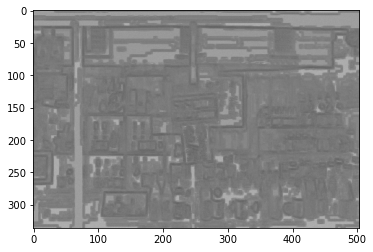

In [57]:
plt.imshow(pt2np(weights_map_to_image(weight_maps_pyramid[0], patch_size=config.patch_size)))

In [80]:
image = imread("/home/itaian/tmp/input.jpg")
jp = degrade(image, "jpeg", 5)
imwrite("/home/itaian/tmp/input_jp.png", pt2np(jp))

small_input = resize(image, scale_factors=0.01).clip(0, 1)
imwrite("/home/itaian/tmp/small_input.png", pt2np(small_input))
small_jp = resize(jp, scale_factors=0.01).clip(0, 1)
imwrite("/home/itaian/tmp/small_jp.png", pt2np(small_jp))

In [79]:
resize?


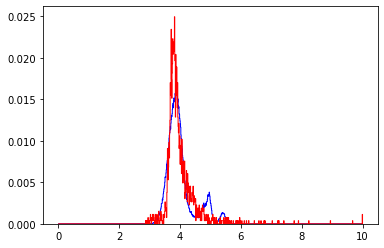

In [58]:
plot_hist(histogram_pyramid[0], start=0, end=10, color="blue")
plot_hist(histogram_pyramid[-1], start=0, end=10, color="red")

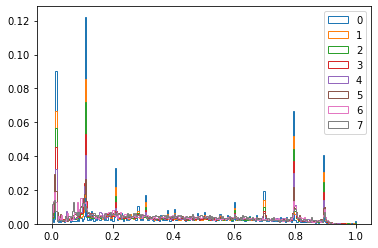

In [72]:
for i in range(8):
    plot_hist(prob_hist(image_pyramid[i].mean(dim=1).flatten(), bins=256, min=0, max=1), start=0, end=1, label=i)
plt.legend()


In [60]:
image_pyramid[2].mean(dim=1).flatten().shape

torch.Size([172720])

# Experiment

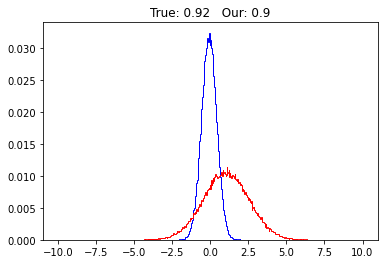

In [35]:
%matplotlib inline

def kld_gauss(u1, s1, u2, s2):
  # general KL two Gaussians
  # u2, s2 often N(0,1)
  # https://stats.stackexchange.com/questions/7440/ +
  # kl-divergence-between-two-univariate-gaussians
  # log(s2/s1) + [( s1^2 + (u1-u2)^2 ) / 2*s2^2] - 0.5
  v1 = s1 * s1
  v2 = s2 * s2
  a = np.log(s2/s1) 
  num = v1 + (u1 - u2)**2
  den = 2 * v2
  b = num / den
  return a + b - 0.5

u1, s1 = -0.1, 0.5
u2, s2 = 1, 1.5
numel = 100000
bins = 500
bounds = 10

# histograms
p = prob_hist(values=torch.normal(mean=u1+torch.zeros(numel), std=s1*torch.ones(numel)), 
              bins=bins, min=-bounds, max=bounds)
q = prob_hist(values=torch.normal(mean=u2+torch.zeros(numel), std=s2*torch.ones(numel)), 
              bins=bins, min=-bounds, max=bounds)

# KLs
kl = kl_divergence(p, q)
true = kld_gauss(u1, s1, u2, s2)

# plot
plot_hist(p, start=-bounds, end=bounds, color="blue")
plot_hist(q, start=-bounds, end=bounds, color="red")
plt.title(f"True: {round(true, 2)}   Our: {round(kl.item(), 2)}")
plt.show()


In [ ]:
def cupy_histogram(x, bins, device='cuda'):
    x = cp.asarray(x)
    bins = cp.asarray(bins)
    hist = cp.histogram(x=x, bins=bins)[0]
    return torch.as_tensor(hist, device=device)


for test in range(10):

    values = torch.rand(4 * 10000).cuda()
    bins = torch.rand(1000, 10000).sort(dim=1).values.cuda()

    # for loop
    start = time.time()
    hists = []
    for bin_idx in range(bins.size(0)):
        hists.append(cupy_histogram(x=values, bins=bins[bin_idx])) 
    hists = torch.stack(hists)
    end = time.time()
    loop = round(end - start, 2)

    # no loop
    start = time.time()
    hists2 = multi_bin_hist(values, bins)
    end = time.time()
    no_loop = round(end - start, 2)
    
    success_rate = round(100 * (hists == hists2).count_nonzero().item() / hists.numel(), 5)
    print(f"Test #{test} - {success_rate}%; loop took {loop}, no_loop took {no_loop}")


# OLD STUFF

## blur-reference-wn histograms 

In [ ]:
num_proj=256
num_noise=256
patch_size=5
base_path = f"/home/itaian/data/results/SWD/IQA"

degradations = ["big_blur", "small_blur", "reference", "small_wn", "big_wn"]
scales = [i for i in range(2, 9)]
colors = ["black", "purple", "blue", "green", "gold", "salmon", "red"]

for image_id in range(1, 19):
    print("Image", image_id)
    # image_id = 1

    fig, axs = plt.subplots(1, 5, figsize=(20, 12))
    fig.suptitle(f'image {image_id}')

    for ax_i, degradation in enumerate(degradations):

        ps = []
        for scale, color in zip(scales, colors):
            # get patch_counts
            base_name = f"image_{image_id}_degradation_{degradation}_scale_{scale}"
            weight_path = f"{base_path}/weights/{base_name}.pt"
            weights = torch.load(weight_path).cuda()
            patch_counts = weights.squeeze().mean(dim=0)[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2].flatten()
            patch_counts = patch_counts.sort().values.cpu().numpy()

            # plot hist
            z = axs[ax_i].hist(patch_counts, bins=1000, range=(2, 8), density=True, histtype="step", color=color, label=scale)
            axs[ax_i].legend()

            # for KL calc
            eps = 1e-4
            p = np.maximum(z[0] / z[0].sum(), eps)
            ps.append(p)

        kldiv = (kl_divergence(ps[0], ps[-1]) + kl_divergence(ps[-1], ps[0])) / 2
        axs[ax_i].set_title(f"{degradation}\nKL {round(kldiv, 4)}")
        
        image_path = f"{base_path}/histograms/image_{image_id}.png"
        os.makedirs(os.path.dirname(image_path), exist_ok=True)
        plt.savefig(fname=image_path, facecolor="white")


## condition numbers

In [ ]:
%matplotlib inline
from torchmetrics.functional import image_gradients
import torch.nn.functional as F
import matplotlib.pyplot as plt

for image_id in range(16, 17):
    print("Image", image_id)
    for degradation in degradations:
        for scale in scales:
            
            # read image
            base_name = f"image_{image_id}_degradation_{degradation}_scale_{scale}"
            image_path = f"{base_path}/dataset_pyramid/{base_name}.png"
            image = imread(image_path)
            h, w = image.shape[-2:]
            h_, w_ = h - (patch_size - 1), w - (patch_size - 1)

            # Lucas Kanade
            gray_image = image.mean(dim=1).unsqueeze(1)
            dy, dx = image_gradients(gray_image)
            dy = F.unfold(dy, kernel_size=patch_size).squeeze().t().reshape(h_, w_, patch_size, patch_size)
            dx = F.unfold(dx, kernel_size=patch_size).squeeze().t().reshape(h_, w_, patch_size, patch_size)
            LK = torch.stack([dx.pow(2).sum(dim=(2, 3)), 
                              (dx * dy).sum(dim=(2, 3)), 
                              (dx * dy).sum(dim=(2, 3)), 
                              dy.pow(2).sum(dim=(2, 3))], dim=2)
            LK = LK.reshape(h_, w_, 2, 2)

            # condition numbers
            eps = 1e-2
            singular_values = torch.linalg.svd(LK).S
            condition_numbers = singular_values[:, :, 0] / (singular_values[:, :, -1] + eps)
            condition_numbers = condition_numbers.view(1, 1, h_, w_)
            condition_numbers_plt = F.pad(condition_numbers, pad=[patch_size // 2] * 4, value=0)

            # plot condition number
            plt.imshow(condition_numbers_plt.squeeze().unsqueeze(-1).numpy())
            plt.colorbar()
            plt.title("Condition Numbers")
            plt.savefig(fname=f"{base_path}/LK_condition_numbers/{base_name}.png", facecolor="white")
            plt.close()


## interactive buttons

In [ ]:
@widgets.interact_manual(
    image_id=[i for i in range(1, 801)], 
    hr_scale=[2**i for i in range(0, 5)],
    degradation=["reference", "small_wn", "big_wn", "small_blur", "big_blur"], 
    num_proj=[2**i for i in range(6, 12)], 
    num_noise=[2**i for i in range(6, 12)])
def update(image_id=1, hr_scale=4, degradation="reference", num_proj=128, num_noise=512):

    # images
    hr_image = imread(os.path.join(config.DATASET_PATH, f'{image_id:04d}.png')).cuda()
    hr_image = resize(input=hr_image, scale_factors=1/hr_scale, pad_mode='reflect').clip(0, 1)
    hr_image = degrade(reference=hr_image, degradation=degradation).clip(0, 1)
    lr_image = resize(input=hr_image, scale_factors=0.5, pad_mode='reflect').clip(0, 1)
    image_path = f"/home/itaian/data/results/SWD/IQA/image_{image_id}_hr_scale_{hr_scale}_degradation_{degradation}_num_proj_{num_proj}_num_noise_{num_noise}"
    imwrite(fname=f"{image_path}_hr.png", image=pt2np(hr_image))
    imwrite(fname=f"{image_path}_lr.png", image=pt2np(lr_image))
    
    # projections
    proj_path = f"/home/itaian/data/projections/{num_proj}_{config.patch_size}.pt"
    if os.path.exists(proj_path):
        proj = torch.load(proj_path).cuda()
    else:
        proj = sample_random_projections(patch_size=config.patch_size, num_proj=num_proj)
        os.makedirs(os.path.dirname(proj_path), exist_ok=True)
        torch.save(proj, proj_path)

    # weight maps
    weight_path = f"/home/itaian/data/weights/image_{image_id}_hr_scale_{hr_scale}_degradation_{degradation}_num_proj_{num_proj}_num_noise_{num_noise}.pt"
    if os.path.exists(weight_path):
        weights = torch.load(weight_path).cuda()
        print("weights loaded")
    else:
        h, w = lr_image.shape[-2:]
        weights = torch.zeros(num_proj, 1, h, w)
        for _ in tqdm(range(num_noise)):
            weights += best_projection_weights(hr_image=add_noise(hr_image), lr_image=add_noise(lr_image), rand=proj).float().cpu()
        weights = weights / num_noise
        os.makedirs(os.path.dirname(weight_path), exist_ok=True)
        torch.save(weights, weight_path)
        imwrite(fname=weight_path[:-2]+".png", image=pt2np(weights.mean(dim=0, keepdims=True).repeat([1, 3, 1, 1]).clip(0, 8)/8))
        print("weights computed")

    # update state
    state.lr_image = pt2np(lr_image)
    state.weights = weights

def on_press(event):
    with open("/home/itaian/tmp/tmp/notebook.log", "ab") as f:
        # get pressed location
        h, w = floor(event.ydata), floor(event.xdata)

        patch_counts = sorted(state.weights.squeeze(dim=1)[:, h, w].tolist())
        mean = sum(patch_counts) / len(patch_counts)
        
        title = f'Mean: {round(mean, 3)}; Location: ({h}, {w})\n'
        f.write(title.encode())
        f.write(f'Counts: {patch_counts}\n'.encode())
        
        ax2.clear()
        ax2.hist(patch_counts, bins=[(i/3) for i in range(3*50)])
        ax2.set_title(title)
        fig.canvas.draw()
        
        f.write(f'\n'.encode())


# create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [7, 3]})
# connect figure to function
cid = fig.canvas.mpl_connect('button_press_event', on_press)
# plot image
ax1.imshow(state.lr_image)


In [ ]:
from competitors.CONTRIQUE.contrique import contrique_score
from competitors.HyperIQA.hyper_iqa import hyper_iqa_score
from competitors.utils import get_gt_scores, plot_result


method_funcs = {"CONTRIQUE": contrique_score, 
                "HyperIQA": hyper_iqa_score}
datasets = ["LIVE", "CSIQ", "LIVE_Challenge"]

method_name = "HyperIQA"
for train_dataset_name in ["LIVE"]:
    for test_dataset_name in datasets:
        print(train_dataset_name, test_dataset_name)
        method_scores = method_funcs[method_name](train_dataset_name=train_dataset_name, test_dataset_name=test_dataset_name)
        gt_scores = get_gt_scores(dataset_name=test_dataset_name)
        plot_result(gt_scores=gt_scores, method_scores=method_scores, 
                    method_name=method_name, 
                    train_dataset_name=train_dataset_name, test_dataset_name=test_dataset_name)


<IPython.core.display.Javascript object>


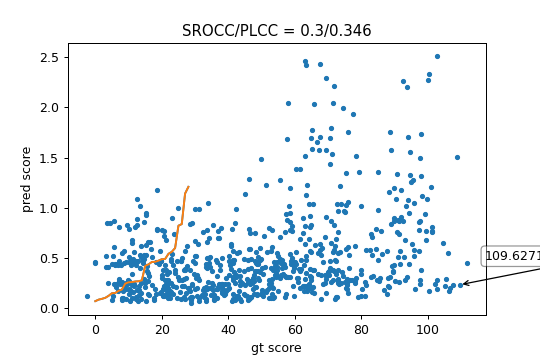

In [137]:
%matplotlib notebook
import glob
import numpy as np; np.random.seed(1)
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from utils import read_pickle, plot_hist
from swd import weights_map_to_image


def load_results_from_dir(results_dir):
    results = dict()
    for file_name in sorted(os.listdir(results_dir)):
        file_path = os.path.join(results_dir, file_name)
        results[file_name] = read_pickle(file_path=file_path)
    return results
    

def debug_results(results, image_name):
    #    image_pyramid
    for image_idx, image in enumerate(results[image_name]['image_pyramid']):
        imwrite(fname=f"./results/{image_name}/image_pyramid_{image_idx}.png", image=pt2np(image))
    #    weight_maps_pyramid
    for weight_idx, weight_map in enumerate(results[image_name]['weight_maps_pyramid']):
        weight_map = weights_map_to_image(weight_map, patch_size=config.patch_size)
        imwrite(fname=f"./results/{image_name}/weight_map_{weight_idx}.png", image=pt2np(weight_map))
    #    histogram_pyramid 
    # hist
    plt.close()
    for hist_idx, hist in enumerate(results[image_name]['histogram_pyramid']):
        plot_hist(hist=hist, start=0, end=10, label=hist_idx)
    plt.legend()
    # title
    kldivs = round(results[image_name]['kldivs'][0].item(), 2), round(results[image_name]['kldivs'][1].item(), 2)
    score = round(results[image_name]['score'], 2)
    plt.title(f"score: {score}\nkldivs: {kldivs}")
    # save
    histogram_pyramid_path = f"./results/{image_name}/histogram_pyramid.png"
    os.makedirs(os.path.dirname(histogram_pyramid_path), exist_ok=True)
    plt.savefig(histogram_pyramid_path, facecolor='white')
    plt.close()

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format(" ".join([image_names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)
    

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()


results_dir = "./results/OURS_LIVE"
results = load_results_from_dir(results_dir=results_dir)

# degradations = ["gblur", "wn", "jpeg", "fastfading", "jp2k"] # ["gblur", "wn", "jpeg", "fastfading", "jp2k"]
# image_names = [key for key in sorted(list(results.keys())) if key.split("_")[4] in degradations]
image_names = [key for key in sorted(list(results.keys())) if "carnivaldolls" not in key]
# image_names = [image_name for image_name in image_names if 30 < float(image_name.split("_")[0]) < 70]
gt_scores = [float(image_name.split("_")[0]) for image_name in image_names]
method_scores = [results[image_name]['score'] for image_name in image_names]

fig,ax = plt.subplots()
sc = plt.scatter(x=gt_scores, y=method_scores, s=10)
annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)
fig.canvas.mpl_connect("motion_notify_event", hover)
srocc = spearmanr(gt_scores, method_scores).correlation
plcc = pearsonr(gt_scores, method_scores)[0]
plt.title(f"SROCC/PLCC = {round(srocc, 3)}/{round(plcc, 3)}")
plt.xlabel("gt score")
plt.ylabel(f"pred score")
plt.show()

In [ ]:
# gblur      -  0.39/0.42 ;  0.32/0.33
# wn         -  0.33/0.26 ;  0.59/0.60
# jpeg       -  0.31/0.41 ; -0.19/-0.16
# fastfading -  0.23/0.24 ;  0.16/0.12
# jp2k       -  0.15/0.12 ;  0.11/0.08


In [121]:
weight_map = results[image_name]['weight_maps_pyramid'][0]
hist = results[image_name]['histogram_pyramid'][0]

In [122]:
weight_map.mean()

tensor(4.)

In [130]:
(hist.cpu() * np.array([i*10/len(hist) for i in range(len(hist))])).sum()

tensor(4.0147, dtype=torch.float64)

In [129]:
np.array([i*10/len(hist) for i in range(len(hist))]).shape

(1000,)

<IPython.core.display.Javascript object>


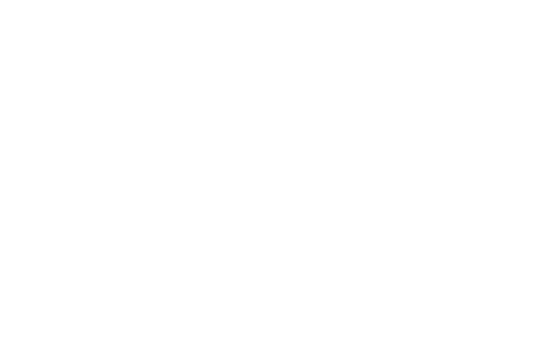

In [132]:
image_name = "004.3269__carnivaldolls__jpeg__img14.bmp"
debug_results(results=results, image_name=image_name)

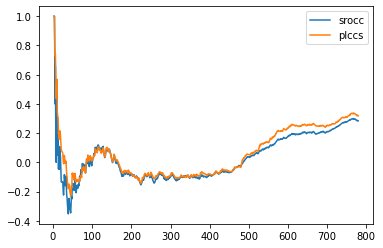

In [90]:
%matplotlib inline

sroccs = []
plccs = []
n = len(gt_scores)
for i in range(2, n+1):
    sroccs.append(spearmanr(gt_scores[:i], method_scores[:i]).correlation)
    plccs.append(pearsonr(gt_scores[:i], method_scores[:i])[0])
plt.plot([i for i in range(2, n+1)], sroccs, label="srocc")
plt.plot([i for i in range(2, n+1)], plccs, label="plccs")
plt.legend()
plt.show()


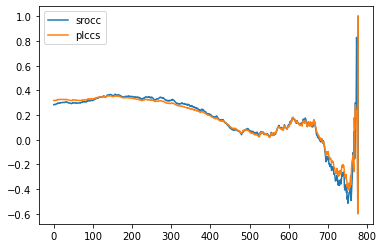

In [91]:
%matplotlib inline

sroccs = []
plccs = []
n = len(gt_scores)
for i in range(0, n-1):
    sroccs.append(spearmanr(gt_scores[i:], method_scores[i:]).correlation)
    plccs.append(pearsonr(gt_scores[i:], method_scores[i:])[0])
plt.plot([i for i in range(0, n-1)], sroccs, label="srocc")
plt.plot([i for i in range(0, n-1)], plccs, label="plccs")
plt.legend()
plt.show()


In [141]:
from IQA.main import our_score
from IQA.config import default_config as config
from tqdm import tqdm
config.debug=False

ref_path = "/home/itaian/group/datasets/LIVE/refimgs"
scores = []
for image_name in sorted(os.listdir(ref_path)):
    print(image_name)
    config.image_path = os.path.join(ref_path, image_name)
    scores.append(our_score(image=imread(config.image_path).cuda(), config=config))
    

bikes.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.43it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
building2.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 18.16it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
buildings.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 18.23it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
caps.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.05it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
carnivaldolls.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 23.93it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
cemetry.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 25.07it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
churchandcapitol.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 18.24it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
coinsinfountain.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.24it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
dancers.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.70it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
flowersonih35.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:05<00:00, 12.23it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
house.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 15.72it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
lighthouse.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.55it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
lighthouse2.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.50it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
manfishing.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.75it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
monarch.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 18.12it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
ocean.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.29it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
paintedhouse.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.64it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
parrots.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.36it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
plane.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.43it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
rapids.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.31it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
sailing1.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.72it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
sailing2.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.64it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
sailing3.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 13.56it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
sailing4.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.86it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
statue.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.71it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
stream.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 17.89it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
studentsculpture.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 18.31it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
woman.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 16.11it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
womanhat.bmp
Image Pyramid Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 18.03it/s]

Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.


In [162]:
sorted_scores, indices = torch.tensor(scores).sort()
sorted_image_names = [sorted(os.listdir(ref_path))[i] for i in indices.tolist()]

In [167]:
for i in range(len(os.listdir(ref_path))):
    print(sorted_image_names[i], " "*(30-len(sorted_image_names[i])), sorted_scores[i].item())

bikes.bmp                       0.0712115466594696
buildings.bmp                   0.08631537109613419
dancers.bmp                     0.09441106021404266
cemetry.bmp                     0.1044207364320755
lighthouse.bmp                  0.12433671951293945
paintedhouse.bmp                0.15011298656463623
building2.bmp                   0.1527518332004547
woman.bmp                       0.1738276481628418
coinsinfountain.bmp             0.1870463788509369
sailing3.bmp                    0.24576199054718018
churchandcapitol.bmp            0.2590055465698242
monarch.bmp                     0.2608528137207031
sailing2.bmp                    0.266838014125824
house.bmp                       0.2691846191883087
stream.bmp                      0.2780529260635376
sailing1.bmp                    0.42262208461761475
ocean.bmp                       0.43708086013793945
sailing4.bmp                    0.4608992040157318
studentsculpture.bmp            0.46270519495010376
statue.bmp              

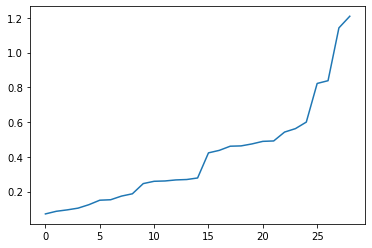

In [170]:
%matplotlib inline

plt.plot(sorted_scores)
plt.show()

In [145]:
[0.0712115466594696,
 0.1527518332004547,
 0.08631537109613419,
 1.1419224739074707,
 1.2089686393737793,
 0.1044207364320755,
 0.2590055465698242,
 0.1870463788509369,
 0.09441106021404266,
 0.5997573137283325,
 0.2691846191883087,
 0.12433671951293945,
 0.542264997959137,
 0.5620946884155273,
 0.2608528137207031,
 0.43708086013793945,
 0.15011298656463623,
 0.8221670985221863,
 0.8379920721054077,
 0.4911835491657257,
 0.42262208461761475,
 0.266838014125824,
 0.24576199054718018,
 0.4608992040157318,
 0.47402969002723694,
 0.2780529260635376,
 0.46270519495010376,
 0.1738276481628418,
 0.48883724212646484]

[0.0712115466594696,
 0.1527518332004547,
 0.08631537109613419,
 1.1419224739074707,
 1.2089686393737793,
 0.1044207364320755,
 0.2590055465698242,
 0.1870463788509369,
 0.09441106021404266,
 0.5997573137283325,
 0.2691846191883087,
 0.12433671951293945,
 0.542264997959137,
 0.5620946884155273,
 0.2608528137207031,
 0.43708086013793945,
 0.15011298656463623,
 0.8221670985221863,
 0.8379920721054077,
 0.4911835491657257,
 0.42262208461761475,
 0.266838014125824,
 0.24576199054718018,
 0.4608992040157318,
 0.47402969002723694,
 0.2780529260635376,
 0.46270519495010376,
 0.1738276481628418,
 0.48883724212646484]

In [ ]:
[0.0712115466594696,
 0.1527518332004547,
 0.08631537109613419,
 1.1419224739074707,
 1.2089686393737793,
 0.1044207364320755,
 0.2590055465698242,
 0.1870463788509369,
 0.09441106021404266,
 0.5997573137283325,
 0.2691846191883087,
 0.12433671951293945,
 0.542264997959137,
 0.5620946884155273,
 0.2608528137207031,
 0.43708086013793945,
 0.15011298656463623,
 0.8221670985221863,
 0.8379920721054077,
 0.4911835491657257,
 0.42262208461761475,
 0.266838014125824,
 0.24576199054718018,
 0.4608992040157318,
 0.47402969002723694,
 0.2780529260635376,
 0.46270519495010376,
 0.1738276481628418,
 0.48883724212646484]

In [41]:
import glob

base_dir = "./results/0_DIV2K_20_replicate_previous_results"

image_names = [os.path.basename(image_path).split(".")[0] for image_path in sorted(glob.glob("./images/DIV2K_20_chosen/*"))]
degradations = ['gauss_blur', 'white_noise']
severities = [i for i in range(8)]

# image_name = "0001"
# degradation = "gauss_blur"
for image_name in image_names:
    for degradation in degradations:
        kldivs = [[None for severity in severities], [None for severity in severities]]
        for result_name in os.listdir(os.path.join(base_dir, "empty")):
            result_name = result_name[:-6]
            result_image_name, result_degradation, result_severiy, result_kldiv_0, result_kldiv_1 = result_name.split("--")
            if (result_image_name == image_name) and (result_degradation == degradation):
                kldivs[0][int(result_severiy)] = float(result_kldiv_0)
                kldivs[1][int(result_severiy)] = float(result_kldiv_1)
        title = f"{image_name}_{degradation}"
        fig = plt.figure(facecolor=(1, 1, 1))
        plt.scatter([i for i in range(8)], kldivs[0], color="blue")
        plt.scatter([i for i in range(8)], kldivs[1], color="red")
        plt.xlabel("severity")
        plt.ylabel("KL div")
        plt.ylim(0, 2.5)
        plt.title(title)
        os.makedirs(os.path.join(base_dir, "graphs"), exist_ok=True)
        plt.savefig(os.path.join(base_dir, "graphs", f"{title}.png"))
        plt.close()
        

<IPython.core.display.Javascript object>


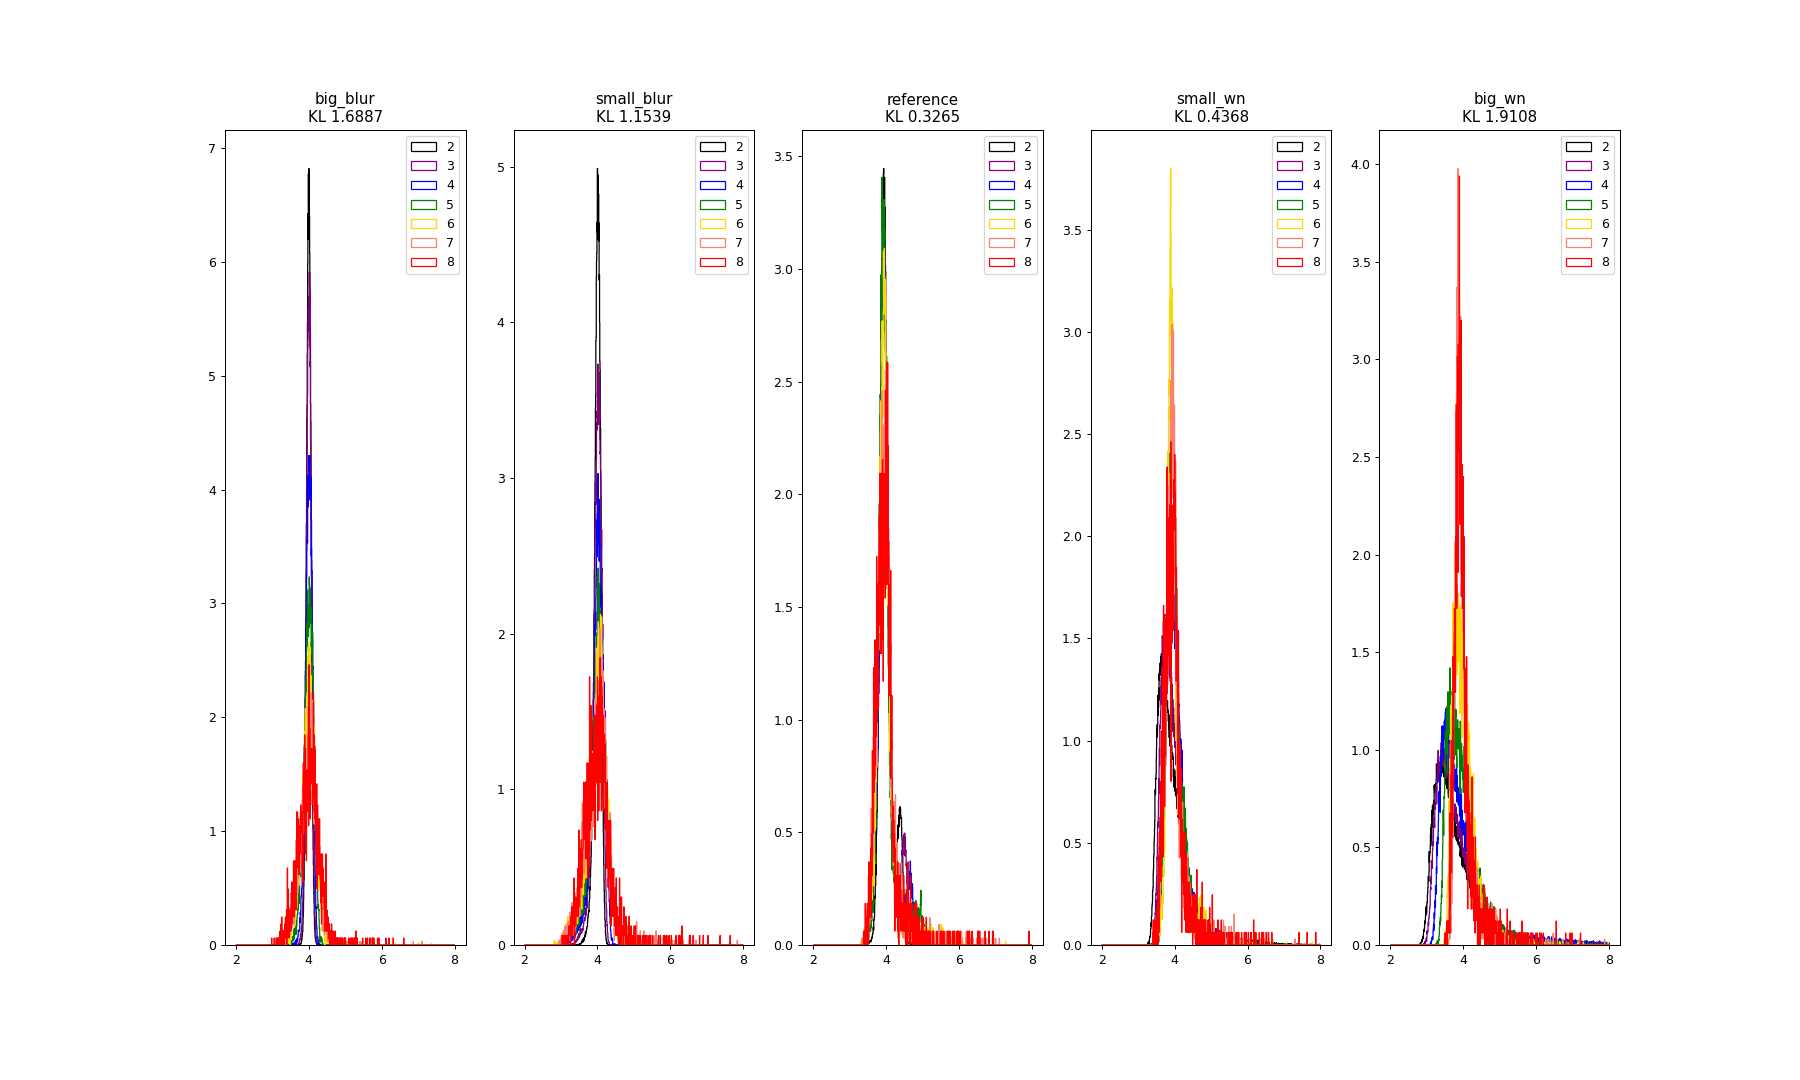

start
big_blur
2. 3. 4. 5. 6. 7. 8. small_blur
2. 3. 4. 5. 6. 7. 8. reference
2. 3. 4. 5. 6. 7. 8. small_wn
2. 3. 4. 5. 6. 7. 8. big_wn
2. 3. 4. 5. 6. 7. 8. 

In [36]:
patch_size=5
degradations = ["big_blur", "small_blur", "reference", "small_wn", "big_wn"]
scales = [i for i in range(2, 9)]
colors = ["black", "purple", "blue", "green", "gold", "salmon", "red"]

fig, axs = plt.subplots(1, 5, figsize=(20, 12))

print("start")

for ax_i, degradation in enumerate(degradations):
    print(degradation)

    for scale, color in zip(scales, colors):
        print(scale, end=". ")
        # get patch_counts
        weights = results_dict[degradation]['weight_maps_pyramid'][scale-2].cuda()
        patch_counts = weights.squeeze().flatten()
        patch_counts = patch_counts.sort().values.cpu().numpy()

        # plot hist
        z = axs[ax_i].hist(patch_counts, bins=1000, range=(2, 8), density=True, histtype="step", color=color, label=scale)
        axs[ax_i].legend()

    # kldiv = (kl_divergence(ps[0], ps[-1]) + kl_divergence(ps[-1], ps[0])) / 2
    axs[ax_i].set_title(f"{degradation}\nKL {round(results_dict[degradation]['kldivs'].mean().item(), 4)}")

<IPython.core.display.Javascript object>


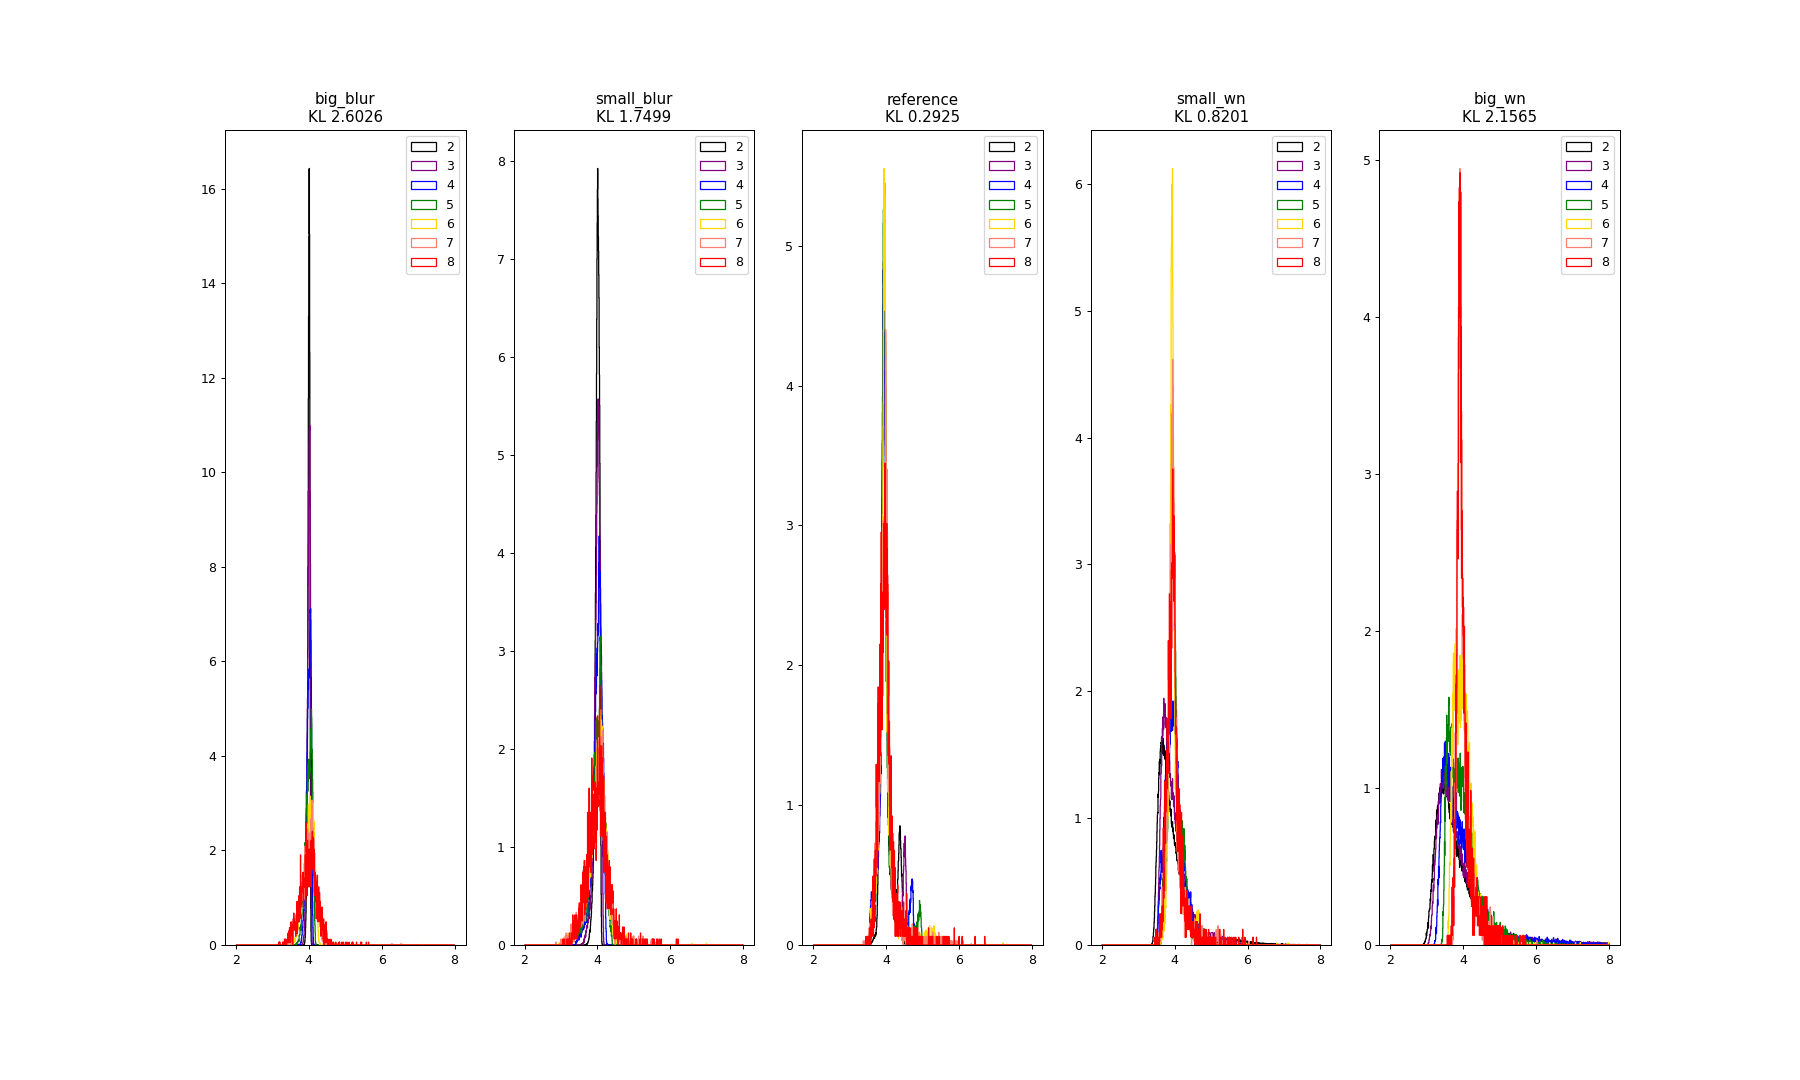

start
big_blur
2. 3. 4. 5. 6. 7. 8. small_blur
2. 3. 4. 5. 6. 7. 8. reference
2. 3. 4. 5. 6. 7. 8. small_wn
2. 3. 4. 5. 6. 7. 8. big_wn
2. 3. 4. 5. 6. 7. 8. 

In [4]:
patch_size=5
degradations = ["big_blur", "small_blur", "reference", "small_wn", "big_wn"]
scales = [i for i in range(2, 9)]
colors = ["black", "purple", "blue", "green", "gold", "salmon", "red"]

fig, axs = plt.subplots(1, 5, figsize=(20, 12))

print("start")

for ax_i, degradation in enumerate(degradations):
    print(degradation)

    for scale, color in zip(scales, colors):
        print(scale, end=". ")
        # get patch_counts
        weights = results_dict[degradation]['weight_maps_pyramid'][scale-2].cuda()
        patch_counts = weights.squeeze().flatten()
        patch_counts = patch_counts.sort().values.cpu().numpy()

        # plot hist
        z = axs[ax_i].hist(patch_counts, bins=1000, range=(2, 8), density=True, histtype="step", color=color, label=scale)
        axs[ax_i].legend()

    # kldiv = (kl_divergence(ps[0], ps[-1]) + kl_divergence(ps[-1], ps[0])) / 2
    axs[ax_i].set_title(f"{degradation}\nKL {round(results_dict[degradation]['kldivs'].mean().item(), 4)}")

In [35]:
results_dict[degradation]['kldivs'].mean().item()

1.9107776880264282

In [21]:
plt.hist?

In [26]:
results_dict['weight_maps_pyramid'][0].device

device(type='cpu')

In [16]:
def kl_divergence(p, q):
#     p, q = torch.from_numpy(p), torch.from_numpy(q)
    eps = torch.tensor(1e-4)
    p, q = torch.maximum(p, eps), torch.maximum(q, eps)

    numel = p.numel()
    # compute kl-div(p|q)
    kl_div = F.kl_div(q.log(), p, reduction='batchmean') * numel
    return kl_div.item()


kldiv = (kl_divergence(results_dict['histogram_pyramid'][0], results_dict['histogram_pyramid'][-1]) + \
         kl_divergence(results_dict['histogram_pyramid'][-1], results_dict['histogram_pyramid'][0])) / 2
print(kldiv)



0.2933821380138397


In [19]:
results_dict['kldivs']

tensor([0.2646, 0.4006])

<IPython.core.display.Javascript object>


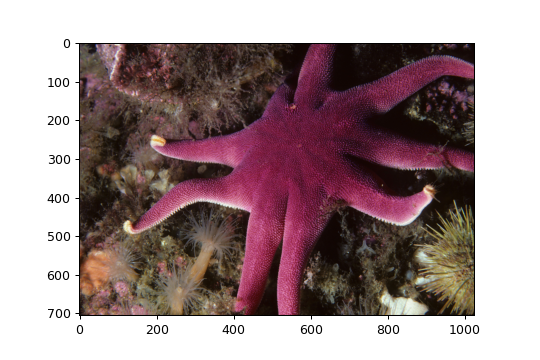

In [12]:
plt.imshow(pt2np(image))
plt.show()

<IPython.core.display.Javascript object>


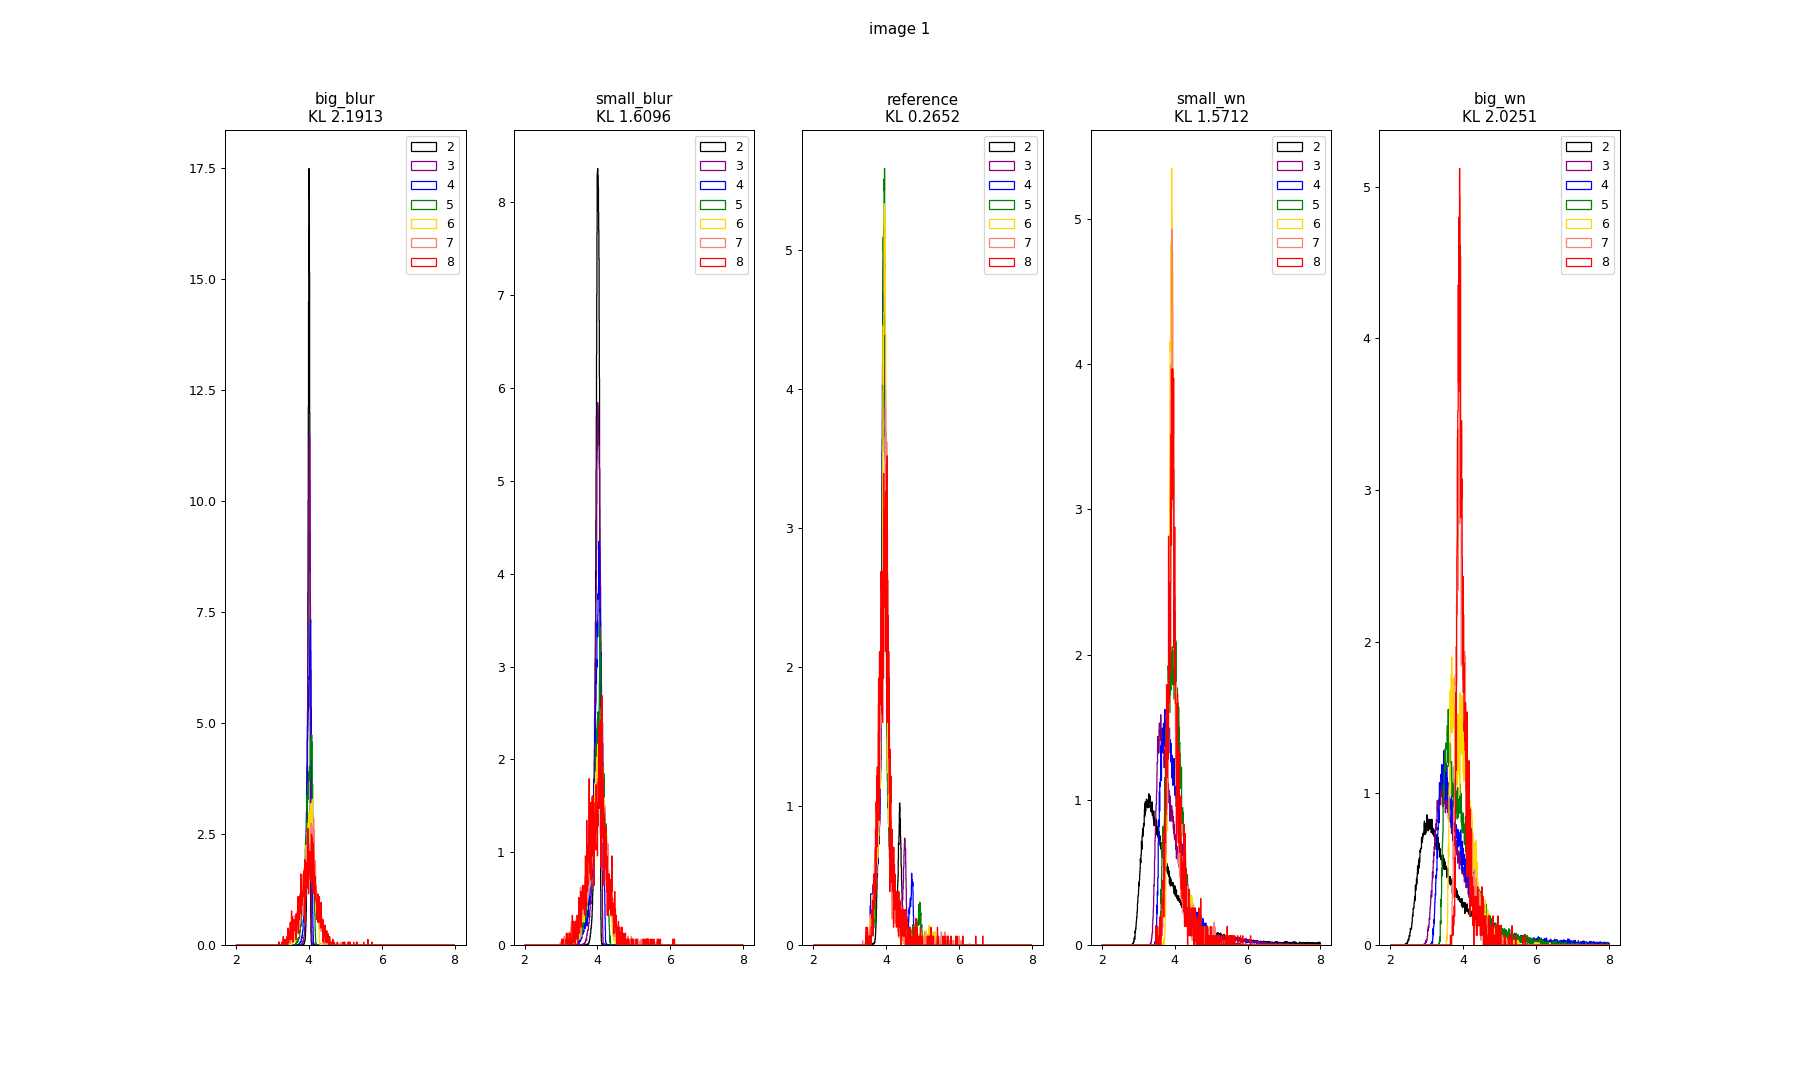

start
big_blur
2. 
3. 
4. 
5. 
6. 
7. 
8. 
small_blur
2. 
3. 
4. 
5. 
6. 
7. 
8. 
reference
2. 
3. 
4. 
5. 
6. 
7. 
8. 
small_wn
2. 
3. 
4. 
5. 
6. 
7. 
8. 
big_wn
2. 
3. 
4. 
5. 
6. 
7. 
8. 


In [5]:
def kl_divergence(p, q):
    p, q = torch.from_numpy(p), torch.from_numpy(q)
    numel = p.numel()
    # compute kl-div(p|q)
    kl_div = F.kl_div(q.log(), p, reduction='batchmean') * numel
    return kl_div.item()


num_proj=256
num_noise=256
patch_size=5
base_path = f"/home/itaian/data/results/SWD/IQA/Z_EXPERIMTENS/2023_02_15"

degradations = ["big_blur", "small_blur", "reference", "small_wn", "big_wn"]
scales = [i for i in range(2, 9)]
colors = ["black", "purple", "blue", "green", "gold", "salmon", "red"]

image_id = 1
fig, axs = plt.subplots(1, 5, figsize=(20, 12))
fig.suptitle(f'image {image_id}')

print("start")

for ax_i, degradation in enumerate(degradations):
    print(degradation)

    ps = []
    for scale, color in zip(scales, colors):
        print(scale, end=". ")
        # get patch_counts
        base_name = f"image_{image_id}_degradation_{degradation}_scale_{scale}"
        weight_path = f"{base_path}/weights/{base_name}.pt"
        weights = torch.load(weight_path).cuda()
        patch_counts = weights.squeeze().mean(dim=0)[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2].flatten()
        patch_counts = patch_counts.sort().values.cpu().numpy()

        # plot hist
        z = axs[ax_i].hist(patch_counts, bins=1000, range=(2, 8), density=True, histtype="step", color=color, label=scale)
        axs[ax_i].legend()
        
        # for KL calc
        eps = 1e-4
        p = np.maximum(z[0] / z[0].sum(), eps)
        ps.append(p)
        print()

    kldiv = (kl_divergence(ps[0], ps[-1]) + kl_divergence(ps[-1], ps[0])) / 2
    axs[ax_i].set_title(f"{degradation}\nKL {round(kldiv, 4)}")

In [23]:
base_path = f"/home/itaian/data/results/SWD/IQA/Z_EXPERIMTENS/2023_02_15"

image_id = 1
degradation = "reference"
scale = 8
weights = torch.load(f"{base_path}/weights/image_{image_id}_degradation_{degradation}_scale_{scale}.pt").cuda()

In [12]:
for scale in range(2, 9):
    print(scale, tuple(torch.load(f"{base_path}/weights/image_{image_id}_degradation_{degradation}_scale_{scale}.pt").shape[2:]))

2 (348, 508)
3 (248, 364)
4 (176, 256)
5 (126, 184)
6 (90, 130)
7 (65, 94)
8 (47, 67)


In [14]:
image.shape

torch.Size([1, 3, 705, 1024])

In [15]:
pyramid_shapes_scale_sqrt_2(h=705, w=1024, patch_size=5, min_dim_size=40)

[(692, 1012),
 (492, 724),
 (348, 508),
 (248, 364),
 (176, 256),
 (126, 184),
 (90, 130),
 (65, 94),
 (47, 67)]

In [17]:
from IQA.old_pyramid import pyramid_scale_sqrt_2_shapes
pyramid_scale_sqrt_2_shapes(image, num_scales=9, patch_size=5, dim_max_size=1024)

[(692.0, 1012.0),
 (492.0, 724.0),
 (348.0, 508.0),
 (248.0, 364.0),
 (176.0, 256.0),
 (126.0, 184.0),
 (90.0, 130.0),
 (65.0, 94.0),
 (47.0, 67.0)]

In [2]:
import os
import torch
import wandb
from pathlib import Path

from images import imread
from ResizeRight.resize_right import resize

from IQA.pyramid import pyramid_shapes_scale_sqrt_2
from IQA.swd import get_projection, slow_best_projection_weights
from IQA.config import default_config as config
from IQA.utils import kl_divergence, kld_gauss, append_to_results, write_pickle
from IQA.main import our_score

original_image = imread(config.image_path).cuda()

# reshape + degrade
h, w = original_image.shape[2:]
downscale = 1024 / max(h, w)
hr_image = resize(original_image, scale_factors=downscale)

# our code
results = []
for severity in range(8):
    degraded_image = degrade(reference=hr_image, degradation="gauss_blur",  severity=severity)
    results.append(our_score(image=degraded_image, config=config))


Image Pyramid Done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:55<00:00,  4.63it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
Image Pyramid Done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:55<00:00,  4.61it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
Image Pyramid Done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:55<00:00,  4.61it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
Image Pyramid Done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:55<00:00,  4.65it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
Image Pyramid Done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:54<00:00,  4.66it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
Image Pyramid Done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:55<00:00,  4.63it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
Image Pyramid Done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:54<00:00,  4.67it/s]


Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.
Image Pyramid Done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:55<00:00,  4.62it/s]

Weight Maps Pyramid Done.
Histograms Pyramid Done.
KL-div Done.


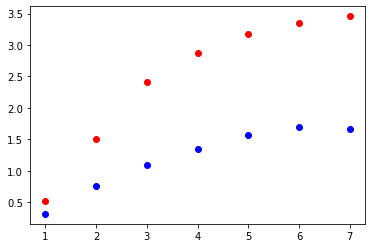

In [4]:
%matplotlib inline

x = [i for i in range(1, 8)]
kldivs_0 = [results[i]['kldivs'][0] for i in range(1, 8)]
kldivs_1 = [results[i]['kldivs'][1] for i in range(1, 8)]
plt.scatter(x, kldivs_0, c="blue")
plt.scatter(x, kldivs_1, c="red")
plt.show()


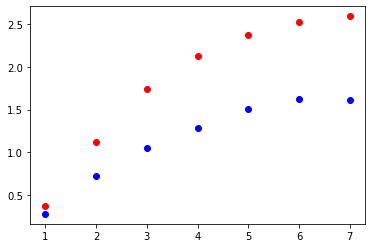

In [11]:
def kl_divergence(p, q):
#     p, q = torch.from_numpy(p), torch.from_numpy(q)

    eps = torch.tensor(1e-4)
    p, q = torch.maximum(p, eps), torch.maximum(q, eps)
    numel = p.numel()
    # compute kl-div(p|q)
    kl_div = F.kl_div(q.log(), p, reduction='batchmean') * numel
    return kl_div.item()


x = [i for i in range(1, 8)]
kldivs_0 = [kl_divergence(results[i]['histogram_pyramid'][0], results[i]['histogram_pyramid'][-1]) for i in range(1, 8)]
kldivs_1 = [kl_divergence(results[i]['histogram_pyramid'][-1], results[i]['histogram_pyramid'][0]) for i in range(1, 8)]
plt.scatter(x, kldivs_0, c="blue")
plt.scatter(x, kldivs_1, c="red")
plt.show()


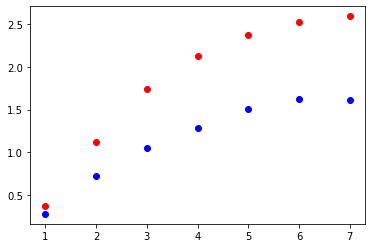

In [42]:
def kl_divergence(p, q):
#     p, q = torch.from_numpy(p), torch.from_numpy(q)

    eps = torch.tensor(1e-4)
    p, q = torch.maximum(p, eps), torch.maximum(q, eps)
    numel = p.numel()
    # compute kl-div(p|q)
    kl_div = F.kl_div(q.log(), p, reduction='batchmean') * numel
    return kl_div.item()


x = [i for i in range(1, 8)]
kldivs_0 = [kl_divergence(results[i]['histogram_pyramid'][0], results[i]['histogram_pyramid'][-1]) for i in range(1, 8)]
kldivs_1 = [kl_divergence(results[i]['histogram_pyramid'][-1], results[i]['histogram_pyramid'][0]) for i in range(1, 8)]
plt.scatter(x, kldivs_0, c="blue")
plt.scatter(x, kldivs_1, c="red")
plt.show()


In [18]:
for i in range(8):
    p = results[i]['histogram_pyramid'][0]
    q = results[i]['histogram_pyramid'][-1]
    assert (type(p) is torch.Tensor) and (type(q) is torch.Tensor)
    assert (p.ndim == 1) and (q.ndim == 1) and (p.numel() == q.numel())
    assert (torch.isclose(p.sum(), torch.tensor(1.))) and (torch.isclose(q.sum(), torch.tensor(1.)))


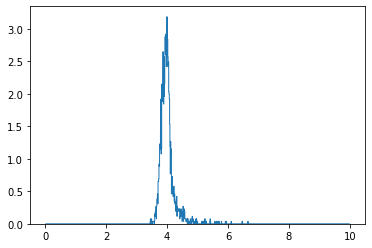

In [38]:
patch_size = 5
patch_counts = weights.squeeze().mean(dim=0)[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2].flatten()
patch_counts = patch_counts.sort().values.cpu().numpy()
z = plt.hist(patch_counts, bins=1000, range=(0, 10), density=True, histtype="step")
eps = 1e-4
p = np.maximum(z[0] / z[0].sum(), eps)


In [39]:
for i in range(1000):
    if sum(p[:i])>=0.5:
        print(i)
        break
        
    

396


In [33]:
patch_counts.shape

(2604,)

In [43]:
import os
import torch
import wandb
from pathlib import Path

from images import imread
from ResizeRight.resize_right import resize

from IQA.pyramid import pyramid_shapes_scale_sqrt_2
from IQA.swd import get_projection, slow_best_projection_weights
from IQA.config import default_config as config
from IQA.utils import kl_divergence, kld_gauss, append_to_results, write_pickle
from IQA.main import our_score

original_image = imread(config.image_path).cuda()

# reshape + degrade
h, w = original_image.shape[2:]
downscale = 1024 / max(h, w)
hr_image = resize(original_image, scale_factors=downscale)

# our code
results = []
for severity in range(8):
    degraded_image = degrade(reference=hr_image, degradation="gauss_blur",  severity=severity)
    results.append(our_score(image=degraded_image, config=config))


Image Pyramid Done.


 44%|█████████████████████████████████████████████████████████████▊                                                                              | 113/256 [01:10<01:28,  1.61it/s]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


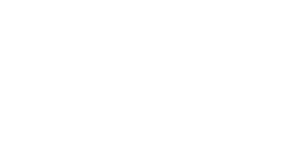

<IPython.core.display.Javascript object>


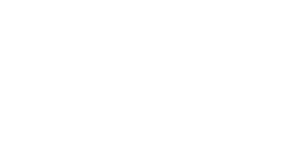

<IPython.core.display.Javascript object>


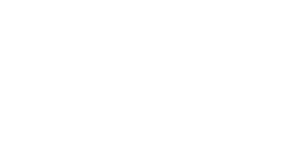

<IPython.core.display.Javascript object>


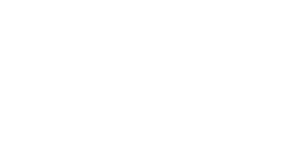

<IPython.core.display.Javascript object>


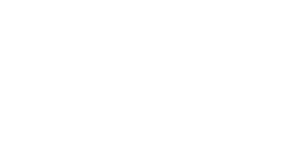

<IPython.core.display.Javascript object>


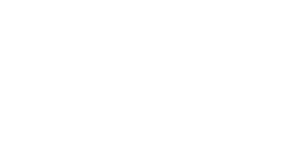

<IPython.core.display.Javascript object>


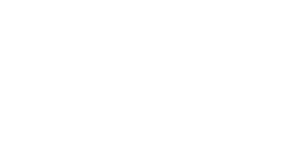

<IPython.core.display.Javascript object>


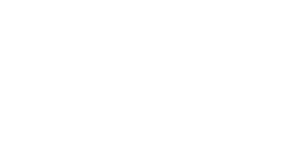

<IPython.core.display.Javascript object>


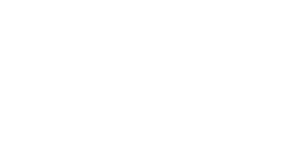

<IPython.core.display.Javascript object>


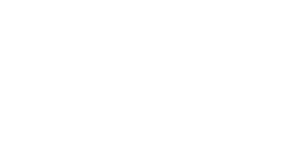

<IPython.core.display.Javascript object>


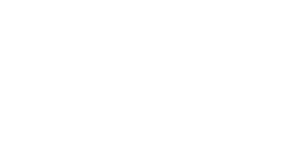

<IPython.core.display.Javascript object>


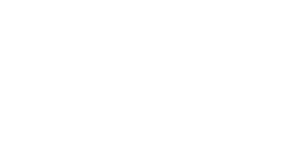

<IPython.core.display.Javascript object>


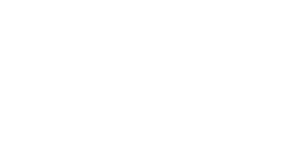

<IPython.core.display.Javascript object>


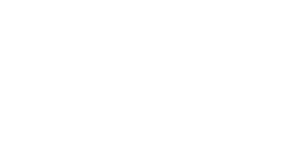

<IPython.core.display.Javascript object>


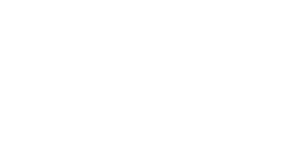

<IPython.core.display.Javascript object>


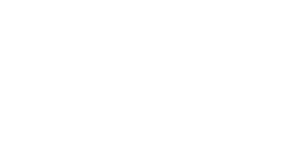

<IPython.core.display.Javascript object>


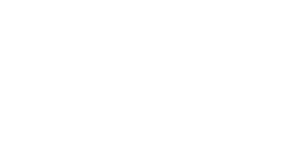

<IPython.core.display.Javascript object>


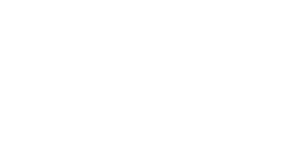

<IPython.core.display.Javascript object>


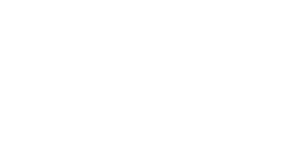

<IPython.core.display.Javascript object>


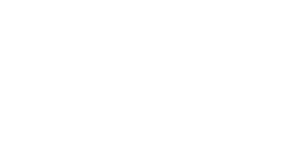

<IPython.core.display.Javascript object>


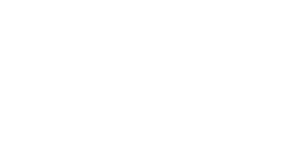

<IPython.core.display.Javascript object>


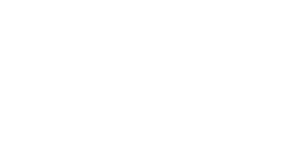

<IPython.core.display.Javascript object>


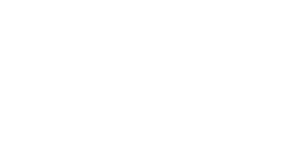

<IPython.core.display.Javascript object>


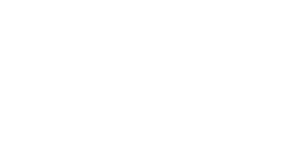

<IPython.core.display.Javascript object>


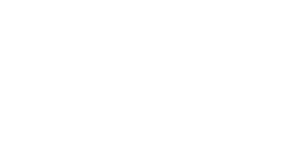

<IPython.core.display.Javascript object>


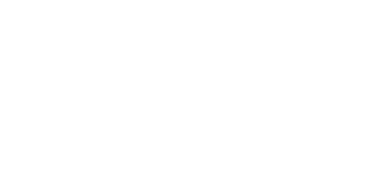

<IPython.core.display.Javascript object>


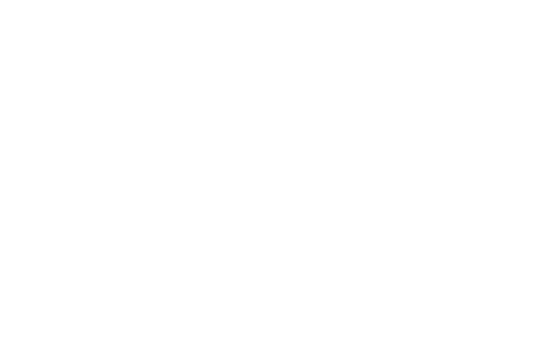

<IPython.core.display.Javascript object>


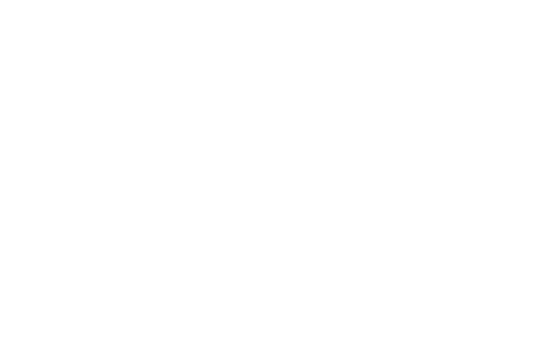

<IPython.core.display.Javascript object>


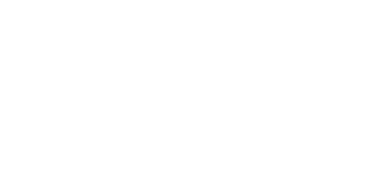

<IPython.core.display.Javascript object>


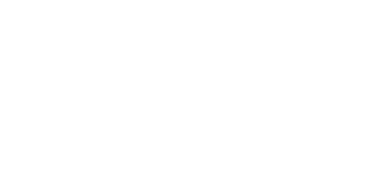

<IPython.core.display.Javascript object>


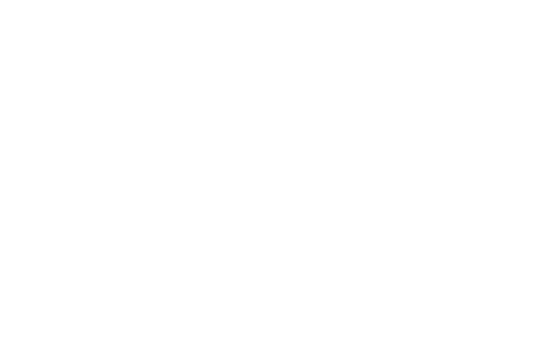

<IPython.core.display.Javascript object>


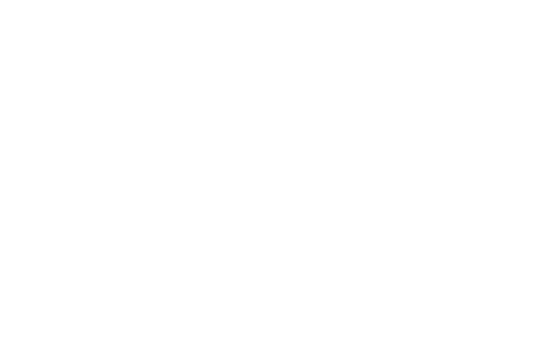

<IPython.core.display.Javascript object>


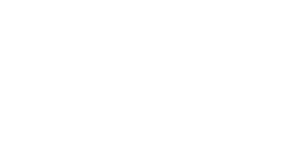

<IPython.core.display.Javascript object>


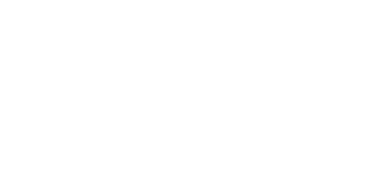

In [61]:
import glob
from IQA.utils import read_pickle
from IQA import sweep_config
import IQA
from importlib import reload
reload(IQA.config)
reload(IQA.sweep_config)
config = IQA.config.default_config
base_dir = config.results_path

degradations = ['gauss_blur', 'white_noise']
image_names = [os.path.basename(image_path).split(".")[0] for image_path in sweep_config.sweep_config['parameters']['image_path']['values']]
num_severities = 7
severities = [i for i in range(num_severities+1)]

# files to dict
result_dict = dict()
for degradation in degradations:
    result_dict[degradation] = dict()
    for image_name in image_names:
        result_dict[degradation][image_name] = torch.full((num_severities+1, 2), torch.nan)
        for severity in severities:
            curr_result = read_pickle(f"{base_dir}/pkl/{degradation}--{image_name}--{severity}.pkl")
            result_dict[degradation][image_name][severity] = curr_result['kldivs']

# dict to graphs
for degradation in degradations:
    for image_name in image_names:
        title = f"{degradation}_{image_name}"
        fig = plt.figure(facecolor=(1, 1, 1))
        plt.scatter(severities, result_dict[degradation][image_name][:, 0], color="blue")
        plt.scatter(severities, result_dict[degradation][image_name][:, 1], color="red")
        plt.xlabel("severity")
        plt.ylabel("KL div")
#         plt.ylim(0, 2.7)
        plt.title(title)
        os.makedirs(os.path.join(base_dir, "graphs"), exist_ok=True)
        plt.savefig(os.path.join(base_dir, "graphs", f"{title}.png"))
        plt.close()

    title = f"{degradation}_mean"
    fig = plt.figure(facecolor=(1, 1, 1))
    kldiv_stack = torch.stack([result_dict[degradation][image_name] for image_name in image_names], dim=0)
    plt.errorbar(x=severities, y=kldiv_stack.mean(dim=0)[:, 0], yerr=kldiv_stack.var(dim=0)[:, 0], c="blue")
    plt.errorbar(x=severities, y=kldiv_stack.mean(dim=0)[:, 1], yerr=kldiv_stack.var(dim=0)[:, 1], c="red")
    plt.xlabel("severity")
    plt.ylabel("KL div")
    plt.title(title)
    os.makedirs(os.path.join(base_dir, "graphs"), exist_ok=True)
    plt.savefig(os.path.join(base_dir, "graphs", f"{title}.png"))
    plt.close()
